In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
# TRAINING PARAMETERS

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3

# for the sake of trial and error change to 20 epochs, recommended amt 50
#EPOCHS=50
EPOCHS=10

In [3]:
# LOAD DATASET

#load data into tensorflow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "AgriAid Images",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 11022 files belonging to 6 classes.


In [4]:
# CLASS NAMES

class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___healthy']

In [5]:
# LENGTH/ SIZE of DATASET per batch

len(dataset)
# the len is 516 becuase every element in the dataset is a batch of 32 images, so 516*32

345

In [6]:
# this gives 1 batch which is 32 images
# output - 32, images each 256x256, 3=rgb channel, so three channels
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[5 5 2 4 5 3 4 0 5 1 2 5 5 2 0 3 0 1 1 0 0 3 5 2 3 1 0 0 0 5 3 2]


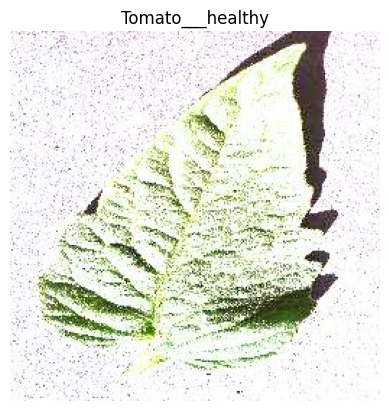

In [7]:
# DATA VISUALIZATION

# 3d array is printed, every number is between 0-255, becuase color is represented with numbers 0-255
# to visualize imgs us plt.imshow, when you do this is expects a 3d array which is "image_batch[0]"
# "image_batch[0]" presents the first img, its a float so ".astype("uint8")" has to be added

for image_batch, label_batch in dataset.take(1):
    #print(image_batch[0].numpy())
    
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    #to display label
    plt.title(class_names[label_batch[0]])
    #to get rid of the side numbers / axis
    plt.axis("off")
    
    #print(image_batch[0].shape)

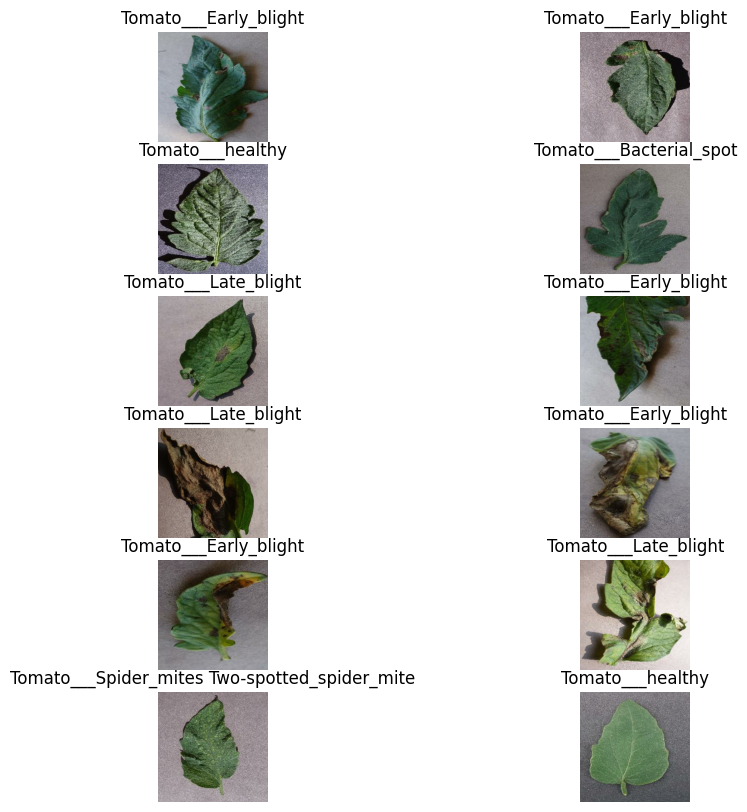

In [8]:
# DATA VISUALIZATION

# Displaying a couple(12) images instead of just one [for the sake of learning]

#to fix dimensions of imgs
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):    
    for i in range(12): # out of 32 images in batch display 12    
        #ax = plt.subplot(3,4,i+1) # matrix of images to show 3x4
        ax = plt.subplot(6,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]]) #display label
        plt.axis("off") #remove axis numbers

In [9]:
# SPLIT DATASET into TRAIN, VALID, TEST

# validation is used during the training process, after each epoch validation is done on 10%
# after the epochs and a model is found the 10% is used to measure the model's accuracy

# 80% ==> training or 60%
# 10% ==> validation or 20%
# 10% ==> test or 20%

training = 0.8
validation = 0.1
test = 0.1

In [10]:
# TRAIN, TEST, SPLIT python function
# TRAIN, TEST SPLIT

# to wrap everything ^ into a python function instead of using the plain numbers
# the goal of this functin is to take the tensorflow dataset and the split ratio
# seed ensures that random processes produce consistent results. It's like setting a starting point for randomness, making your results reproducible when you run the same code multiple times.

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds) #dataset size
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=10)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

276

In [13]:
len(val_ds)

34

In [14]:
len(test_ds)

35

In [15]:
# cache and pre-cache: reads the image from the disc and for the next iteration when you need the same image, will keep that image in memory, so in-turn improving the perforamnce of your pipeline.
# shuffle, shuffles the images
# prefetch- if you are using GPU and CPU, if GPU is busy training, prefetch will load the next set of batch from your disc which will improve the performace.  
# then let tensorflow get the reminder of how many batches to load while the GPU is training

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# PRE-PROCESSING

# Pre-processing layers to be used in model
# scale: the numpy array was between 0-255, which is an RGB scale, you want to divide that by 255 so that you get a number between 0 and 1, to do this
# resizing: resize the imgs to 256 by 256, we do this because when our trained model starts predicting, during prediction if you are supplying images that are not 256 by 256 this function will resize it.

resize_and_rescale = tf.keras.Sequential([
    
    # The error you're encountering indicates that the experimental submodule is not found within the keras.layers module.
    # layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    # layers.experimental.preprocessing.Rescaling(1.0/255)
    
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255) #scale the image to 255
])

In [17]:
# DATA AUGMENTATION

# once this layer is created, apart of the pre-processing is data augmentation.
# this makes the model more robust, in the event that you are supplying images during prediction which may be rotated or different in contrast then the model may not perform well. so this is where data augmentation is valuable and suitable. These imgs may be used for training.

data_augmentation = tf.keras.Sequential([
    
    # layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    # layers.experimental.preprocessing.RandomRotation(0.2),
    
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [18]:
num_classes = len(class_names)
num_classes

6

In [19]:
# MODEL BUILD

# starting with a set of layers
# the number of layers is trial and error, but you need a lot such that you can detect the small features. we are doing 32 layers.
# you'll have the convolutional layer, then the pooling layer

# needing to stack the Maxpooling and cnn layers is based on trial and error
# you can remove a couple layers and figure it out. The 64, 32 numbers are also based on trial and error.
# Once you've stacked the convo and maxpooling layers you'll need to then flatten it, so that its an array of neurons and you can then have a hidden/dense layer and then the final layer is your final output classification layer.

# softmax activation function will normalize the probabilit of the classes.

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = 6

model = models. Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 32)              │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 6)                     │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,926 (398.15 KB)

 Trainable params: 101,926 (398.15 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# COMPILE MODEL

# in deep learining the neural network architecture is first defined then we compile using optimizers like 'adam', the loss fucntion the metrics like in each epoch what type of metric will you use to track the gradient decent, this would be 'accuracy'

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# TRAIN MODEL

# the third step, training the network
# we can record the history of every epoch in the 'history' parameter so we can chart some plot later on.

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3144 - loss: 1.5585